In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install timm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 33.2 MB/s 
     |████████████████████████████████| 163 kB 66.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 30.5 MB/s 
     |████████████████████████████████| 7.6 MB 51.9 MB/s 


In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import BertModel, BertConfig, BertTokenizer

In [ ]:
class CFG:
    debug = False
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-5
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #model_name = 'vit_base_patch32_224_in21k'
    model_name = 'convnext_base_in22ft1k'
    image_embedding = 1024
    text_encoder_model = "bert-base-uncased"
    text_embedding = 768
    text_tokenizer = "bert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

## Image Encoder

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0,
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = BertModel.from_pretrained(model_name)
        else:
            self.model = BertModel(config=BertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

# Our Model

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
def get_model(model_path):
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    return model
model = get_model("/content/gdrive/MyDrive/convnextbert20.pt")
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_22k_1k_224.pth


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model parameters: 197,640,576


In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(CFG.size, interpolation=Image.BICUBIC),
    CenterCrop(CFG.size),
    ToTensor()
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [ ]:
!wget https://farm8.staticflickr.com/6036/6426668771_b5b915e46c_o.jpg
!wget https://c6.staticflickr.com/8/7457/10806045045_02d3dbdcee_o.jpg
!wget https://c1.staticflickr.com/4/3267/2888764405_0a0a608604_o.jpg
!wget https://farm8.staticflickr.com/4028/4294212194_a49663b2b9_o.jpg
!wget https://c5.staticflickr.com/9/8173/8019508216_6540c8686a_o.jpg
!wget https://farm3.staticflickr.com/1146/1357102390_943c5cb999_o.jpg

--2022-10-10 23:29:59--  https://farm8.staticflickr.com/6036/6426668771_b5b915e46c_o.jpg
Resolving farm8.staticflickr.com (farm8.staticflickr.com)... 13.227.255.96, 2600:9000:200a:b400:0:5a51:64c9:c681, 2600:9000:200a:b600:0:5a51:64c9:c681, ...
Connecting to farm8.staticflickr.com (farm8.staticflickr.com)|13.227.255.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5442041 (5.2M) [image/jpeg]
Saving to: ‘6426668771_b5b915e46c_o.jpg’

6426668771_b5b915e4 100%[===================>]   5.19M  4.14MB/s    in 1.3s    

2022-10-10 23:30:00 (4.14 MB/s) - ‘6426668771_b5b915e46c_o.jpg’ saved [5442041/5442041]

--2022-10-10 23:30:00--  https://c6.staticflickr.com/8/7457/10806045045_02d3dbdcee_o.jpg
Resolving c6.staticflickr.com (c6.staticflickr.com)... 13.227.255.96, 2600:9000:200a:b400:0:5a51:64c9:c681, 2600:9000:200a:b600:0:5a51:64c9:c681, ...
Connecting to c6.staticflickr.com (c6.staticflickr.com)|13.227.255.96|:443... connected.
HTTP request sent, awaiting response.

In [ ]:
from glob import glob
files = glob('*.jpg')
print(files)

['10806045045_02d3dbdcee_o.jpg', '4294212194_a49663b2b9_o.jpg', '1357102390_943c5cb999_o.jpg', '2888764405_0a0a608604_o.jpg', '8019508216_6540c8686a_o.jpg', '6426668771_b5b915e46c_o.jpg']


In [ ]:
QUERIES = [
    "a dog",
    "a cat",
    "a elephant",
    "a zebra",
    "a sleeping dog",
    "a sleeping cat",
    "a giraffe",
    "a poodle",
    "animal inside a car",
    "animal outside a car",
    "a sofa",
    "some animals",
    "santa claus",
    "ipod",
    "two mugs",
    "three mugs",
    "blue sky",
] 

10806045045_02d3dbdcee_o.jpg


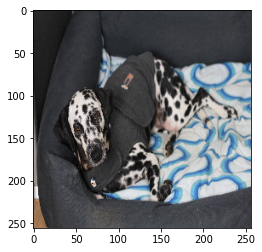

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)


                   query     score
4         a sleeping dog  0.698906
5         a sleeping cat  0.665522
8    animal inside a car  0.647158
9   animal outside a car  0.636444
0                  a dog  0.629984
1                  a cat  0.608623
7               a poodle  0.596371
6              a giraffe  0.588957
13                  ipod  0.572010
10                a sofa  0.551661
11          some animals  0.531864
3                a zebra  0.509637
2             a elephant  0.502275
16              blue sky  0.447361
14              two mugs  0.411198
12           santa claus  0.400269
15            three mugs  0.364982

-------------------------

4294212194_a49663b2b9_o.jpg


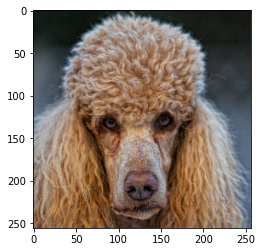

                   query     score
0                  a dog  0.717931
7               a poodle  0.698673
1                  a cat  0.663736
4         a sleeping dog  0.642581
5         a sleeping cat  0.641364
6              a giraffe  0.638836
2             a elephant  0.635328
8    animal inside a car  0.611908
13                  ipod  0.605505
11          some animals  0.591400
9   animal outside a car  0.588405
3                a zebra  0.565193
14              two mugs  0.544296
10                a sofa  0.505884
16              blue sky  0.478909
15            three mugs  0.474335
12           santa claus  0.459533

-------------------------

1357102390_943c5cb999_o.jpg


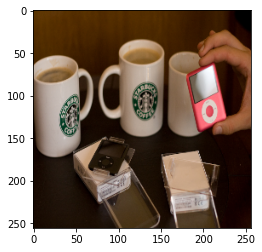

                   query     score
14              two mugs  0.668569
13                  ipod  0.651160
15            three mugs  0.640588
7               a poodle  0.579923
6              a giraffe  0.572970
10                a sofa  0.568551
0                  a dog  0.557636
1                  a cat  0.551622
8    animal inside a car  0.550446
12           santa claus  0.529145
9   animal outside a car  0.528068
2             a elephant  0.515749
5         a sleeping cat  0.513295
4         a sleeping dog  0.504136
11          some animals  0.503138
3                a zebra  0.497989
16              blue sky  0.458123

-------------------------

2888764405_0a0a608604_o.jpg


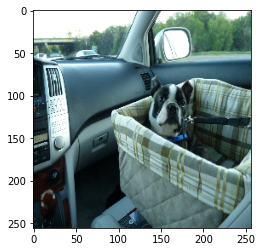

                   query     score
8    animal inside a car  0.740804
9   animal outside a car  0.704159
4         a sleeping dog  0.681629
0                  a dog  0.679563
5         a sleeping cat  0.672287
1                  a cat  0.670892
7               a poodle  0.660769
6              a giraffe  0.646579
11          some animals  0.639328
13                  ipod  0.602424
3                a zebra  0.581580
10                a sofa  0.576916
2             a elephant  0.575165
16              blue sky  0.547803
14              two mugs  0.486347
15            three mugs  0.471551
12           santa claus  0.456075

-------------------------

8019508216_6540c8686a_o.jpg


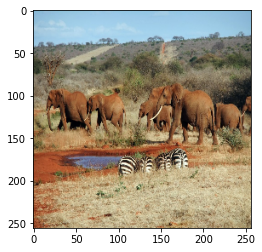

                   query     score
11          some animals  0.691067
3                a zebra  0.657158
2             a elephant  0.645872
6              a giraffe  0.591481
8    animal inside a car  0.574650
9   animal outside a car  0.548630
0                  a dog  0.543203
7               a poodle  0.527055
16              blue sky  0.508416
13                  ipod  0.508083
1                  a cat  0.499961
4         a sleeping dog  0.485125
5         a sleeping cat  0.478942
15            three mugs  0.434559
10                a sofa  0.381593
12           santa claus  0.374410
14              two mugs  0.364299

-------------------------

6426668771_b5b915e46c_o.jpg


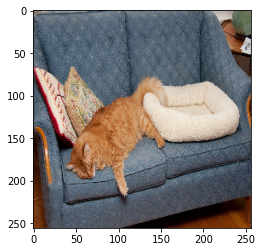

                   query     score
5         a sleeping cat  0.732168
4         a sleeping dog  0.721733
1                  a cat  0.711554
0                  a dog  0.687871
7               a poodle  0.672193
10                a sofa  0.672090
8    animal inside a car  0.630142
6              a giraffe  0.628135
9   animal outside a car  0.602861
2             a elephant  0.602479
13                  ipod  0.592979
11          some animals  0.575297
3                a zebra  0.517711
14              two mugs  0.487352
12           santa claus  0.447695
15            three mugs  0.445514
16              blue sky  0.380415

-------------------------



In [ ]:
with torch.no_grad():
    for file in files:
        print(file)
        # Load image from file
        img = Image.open(file).convert("RGB")

        # Just show image in the notebook
        plt.imshow(cv2.resize(np.array(img), (256, 256)))
        plt.show()
        
        # Preprocess image using clip
        img = preprocess(img).unsqueeze(0).cuda()
        
        image_features = model.image_encoder(img.to(CFG.device)) # Get Image embeddings
        image_features = model.image_projection(image_features)
        image_features = F.normalize(image_features, p=2, dim=-1)
        image_features = image_features.mean(dim=0)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
     
      
        
        score = []
        for query in QUERIES:
            tokenizer = BertTokenizer.from_pretrained(CFG.text_tokenizer)
            texts_2 = tokenizer([query], padding=True, truncation=True, max_length=CFG.max_length)
            batch = {
                     key: torch.tensor(values).to(CFG.device)
                     for key, values in texts_2.items()
                     }
            text_features = model.text_encoder( 
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"] )  # Get Text Embeddings
            text_embeddings = model.text_projection(text_features)   
            class_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm(dim=-1, keepdim=True)
           
            
            # Calc dot product between image and text embeddings
            sc = float((image_features @ class_embedding.T).cpu().numpy())
            score.append(sc)
        
        print( pd.DataFrame({'query': QUERIES, 'score': score}).sort_values('score', ascending=False) )
        print('')
        print('-------------------------')
        print('')